# 💸 Mood & Money: Sentiment-Aware Trading Strategy (Tesla)

This project simulates a simple trading strategy based on the **sentiment of fake Tesla headlines**.  
Using `vaderSentiment` to measure market "mood," the strategy buys TSLA stock when sentiment is positive, and sells when it turns negative. 📈📉



In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt



In [27]:
# Download Tesla stock price data for 2023 (adjust dates as you want)
stock_df = yf.download('TSLA', start='2023-01-01', end='2023-04-30')

# Reset index to have 'Date' as a column
stock_df.reset_index(inplace=True)

# Keep only needed columns
stock_df = stock_df[['Date', 'Close']]

stock_df.head()



[*********************100%***********************]  1 of 1 completed


Price,Date,Close
Ticker,,TSLA
0,2023-01-03,108.099998
1,2023-01-04,113.639999
2,2023-01-05,110.339996
3,2023-01-06,113.059998
4,2023-01-09,119.769997


In [28]:
# For simplicity, create fake headlines matching stock dates
# We'll assign random positive or negative headlines for demo purposes

np.random.seed(42)  # For reproducibility

dates = stock_df['Date']

# Sample headlines (positive and negative)
headlines_list = [
    "Tesla launches new innovative model",
    "Tesla faces production delays",
    "Tesla stock hits record high",
    "Tesla recalls several vehicles",
    "Tesla CEO announces profit increase",
    "Tesla under investigation for safety",
    "Tesla expands to new markets",
    "Tesla delivery numbers disappoint",
]

# Randomly assign headlines to dates
headlines = np.random.choice(headlines_list, size=len(dates))

headlines_df = pd.DataFrame({
    'Date': dates,
    'Headline': headlines
})

headlines_df.head()



,Date,Headline
0,2023-01-03,Tesla expands to new markets
1,2023-01-04,Tesla recalls several vehicles
2,2023-01-05,Tesla CEO announces profit increase
3,2023-01-06,Tesla expands to new markets
4,2023-01-09,Tesla stock hits record high


In [29]:
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment score for each headline
headlines_df['Sentiment'] = headlines_df['Headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

headlines_df.head()






,Date,Headline,Sentiment
0,2023-01-03,Tesla expands to new markets,0.1027
1,2023-01-04,Tesla recalls several vehicles,0.0000
2,2023-01-05,Tesla CEO announces profit increase,0.6369
3,2023-01-06,Tesla expands to new markets,0.1027
4,2023-01-09,Tesla stock hits record high,0.0000


In [31]:
# Flatten multi-level columns to single level if needed
if isinstance(stock_df.columns, pd.MultiIndex):
    stock_df.columns = stock_df.columns.get_level_values(0)

if isinstance(headlines_df.columns, pd.MultiIndex):
    headlines_df.columns = headlines_df.columns.get_level_values(0)


In [32]:
# Merge stock data and headlines on 'Date'
merged_df = pd.merge(stock_df, headlines_df, on='Date', how='left')

# Fill any missing sentiment forward (if any)
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(method='ffill')

merged_df.head()


C:\Users\braki\AppData\Local\Temp\ipykernel_44028\3165298961.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Sentiment'] = merged_df['Sentiment'].fillna(method='ffill')


,Date,Close,Headline,Sentiment
0,2023-01-03,108.099998,Tesla expands to new markets,0.1027
1,2023-01-04,113.639999,Tesla recalls several vehicles,0.0000
2,2023-01-05,110.339996,Tesla CEO announces profit increase,0.6369
3,2023-01-06,113.059998,Tesla expands to new markets,0.1027
4,2023-01-09,119.769997,Tesla stock hits record high,0.0000


In [33]:
# After merging and filling missing sentiment:
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(method='ffill')

# Create a Position column based on sentiment
merged_df['Position'] = merged_df['Sentiment'].apply(lambda x: 1 if x > 0 else -1)

# Calculate strategy returns
strategy_returns = merged_df['Position'].shift(1) * merged_df['Close'].pct_change()
strategy_returns.iloc[0] = 0  # no return on first day




C:\Users\braki\AppData\Local\Temp\ipykernel_44028\3173957630.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Sentiment'] = merged_df['Sentiment'].fillna(method='ffill')


In [34]:
initial_investment = 1000

# Buy & Hold portfolio value (normalized to start at 1000)
buy_and_hold = (merged_df['Close'] / merged_df['Close'].iloc[0]) * initial_investment

# Calculate daily returns for sentiment strategy
strategy_returns = merged_df['Position'].shift(1) * merged_df['Close'].pct_change()
strategy_returns.iloc[0] = 0  # no return on first day

# Cumulative product for portfolio growth
strategy_cum_returns = (1 + strategy_returns).cumprod() * initial_investment




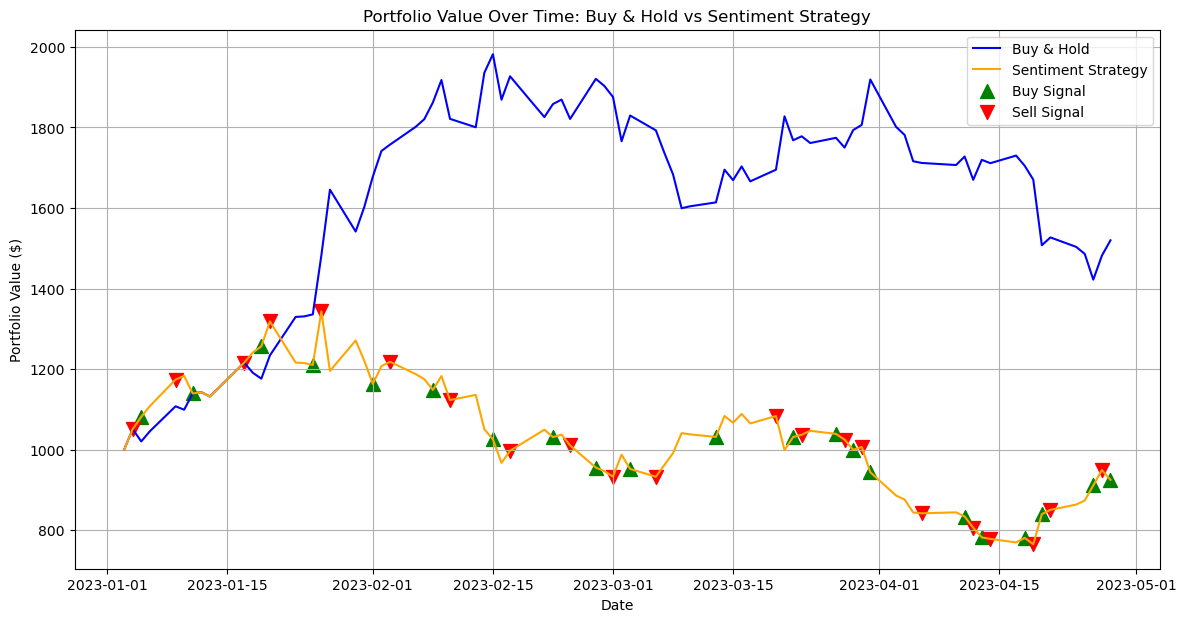

In [37]:
plt.figure(figsize=(14,7))

# Plot Buy & Hold in blue
plt.plot(merged_df['Date'], buy_and_hold, label='Buy & Hold', color='blue')

# Plot Sentiment Strategy in orange
plt.plot(merged_df['Date'], strategy_cum_returns, label='Sentiment Strategy', color='orange')

# Correct Buy/Sell signal logic: look for sentiment flips
buy_signals = merged_df[(merged_df['Position'] == 1) & (merged_df['Position'].shift(1) == -1)]
sell_signals = merged_df[(merged_df['Position'] == -1) & (merged_df['Position'].shift(1) == 1)]

# Plot Buy signals on the orange line (sentiment strategy)
plt.scatter(buy_signals['Date'], 
            strategy_cum_returns[buy_signals.index], 
            marker='^', color='green', s=100, label='Buy Signal')

# Plot Sell signals on the orange line (sentiment strategy)
plt.scatter(sell_signals['Date'], 
            strategy_cum_returns[sell_signals.index], 
            marker='v', color='red', s=100, label='Sell Signal')

plt.title('Portfolio Value Over Time: Buy & Hold vs Sentiment Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
print(f"Initial Investment: ${initial_investment}")
print(f"Buy & Hold Portfolio Value: ${buy_and_hold.iloc[-1]:.2f}")
print(f"Sentiment Strategy Portfolio Value: ${strategy_cum_returns.iloc[-1]:.2f}")

if strategy_cum_returns.iloc[-1] > buy_and_hold.iloc[-1]:
    print("The sentiment strategy outperformed Buy & Hold!")
else:
    print("Buy & Hold outperformed the sentiment strategy.")

Initial Investment: $1000
Buy & Hold Portfolio Value: $1519.98
Sentiment Strategy Portfolio Value: $925.39
Buy & Hold outperformed the sentiment strategy.


##  Summary

- Created a fun, mood-based trading assistant using fake Tesla headlines
- Used sentiment scoring (VADER) to decide when to buy or sell
- Compared strategy against a basic Buy and Hold approach


